# Cats and dogs image enhancement


## Download data from Kaggle

In [1]:
# ! pip install kaggle #it shoul be there(on local one)
# import sys

# # if u are in colab you have to upload your kaggle.json
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
#   from google.colab import files
#   file = files.upload()
#   file_name = next(iter(file))

# # in other case put your kaggle.json in the main project dir
# else: file_name = '../kaggle.json'

# ! mkdir -p ~/.kaggle
# ! echo $file_name
# ! cp $file_name ~/.kaggle/kaggle.json
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [2]:
# download dataset
# ! kaggle competitions download -c dogs-vs-cats
# ! mkdir -p data
# ! unzip -qq -n dogs-vs-cats.zip -d ./
# ! unzip -qq -n ./train.zip -d  data
# ! unzip -qq -n ./test1.zip -d  data
#! rm -f dogs-vs-cats.zip

## Importing and transforming data

In [4]:
from torch.utils.data import  DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.io import read_image

import torch.nn.functional as F

import glob
from random import randint

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchsummary import summary
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

### Custom dataset class

In [5]:
class CatAndDogDataset(Dataset):
    def __init__(self, root_dir, transform=None, transform_upscale=None, transform_downscale=None):
        self.imgs_path = root_dir
        self.file_list = glob.glob(str(self.imgs_path) + "*.jpg")
        self.data = []
        for img_path in self.file_list:
            self.data.append(img_path)

        
        self.transform = transform
        if transform_upscale is not None and transform_downscale is not None:
            self.transform_up = transform_upscale
            self.transform_down = transform_downscale
        else:
          self.transform_up = transforms.Compose(
              [
               transforms.ToPILImage(),
               transforms.Resize((350, 350)),
               transforms.ToTensor()
              ]
          )
          self.transform_down = transforms.Compose(
              [
                transforms.CenterCrop(size=(350, 350))
              ]
          )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.data[idx]
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)
        if self.transform_up:
            image = self.transform_up(image)
        if self.transform_down:
            image = self.transform_down(image)

        return image

### Load and transform image 

In [6]:
# If new data is given set this to None
min_size = (33, 42)
avg_size = (360, 360)
input_size = (180, 180)

transform = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

transform_up = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize(avg_size),
     transforms.ToTensor()]
     )

transform_down = transforms.Compose(
    [transforms.CenterCrop(size=avg_size)]
    )

In [7]:
dataset_train = CatAndDogDataset('./data/train/', transform_upscale=transform_up, transform_downscale=transform_down) #, transform=transform, transform_upscale=transform_up, transform_downscale=transform_down
dataset_test = CatAndDogDataset('./data/test1/', transform_upscale=transform_up, transform_downscale=transform_down)

train_size = int(0.8 * len(dataset_train))
test_size = len(dataset_train) - train_size
dataset_train, dataset_validation = torch.utils.data.random_split(dataset_train, [train_size, test_size])

print(f"DataSet loaded!!!\nTrain set size: {len(dataset_train)}\nValidation size: {len(dataset_validation)}\nTest set size {len(dataset_test)}")

DataSet loaded!!!
Train set size: 20000
Validation size: 5000
Test set size 12500


In [8]:
batch_size = 20

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(dataset_validation, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [9]:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Show sample data

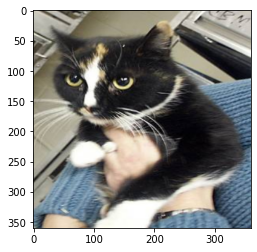

torch.Size([3, 360, 360])


In [10]:
img = dataset_train[randint(0, len(dataset_train))]
imshow(img)
print(img.shape)

In [11]:
print(f"Min size: {min_size}\nAverage size: {avg_size}")

Min size: (33, 42)
Average size: (360, 360)


## Model


### Model definition

In [24]:
class ResolutionEnhancerModel(nn.Module):
    def __init__(self):
        super(ResolutionEnhancerModel, self).__init__()     # input image size: 180 x 180
        self.up_sample = nn.Upsample(2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)    # out image size: 180 x180                                                       # out image size:  90 x 90
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)   # out image size:  359 x 359
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=3, kernel_size=4, stride=1, padding=1)   # out image size: 360 x 360
            
    def forward(self, x):
        x = self.up_sample(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x
    

In [25]:
def train(dataloader, model, loss_fn, optimizer, transform=transforms.Resize((180, 180))):
    size = len(dataloader.dataset)
    model.train()
    train_loss = []
    for batch, (original_image_batch) in enumerate(dataloader):
        if transform:
            t_image_batch = transform(original_image_batch)

        t_image_batch = t_image_batch.to(device)
        original_image_batch = original_image_batch.to(device)
        # Compute prediction error
        pred = model(t_image_batch)
        loss = loss_fn(pred, original_image_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(t_image_batch)
            train_loss.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return (sum(train_loss))/len(train_loss)

In [26]:
def validate(dataloader, model, loss_fn, transform=transforms.Resize((180, 180))):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for original_image_batch in dataloader:
            if transform:
                t_image_batch = transform(original_image_batch)
            t_image_batch = t_image_batch.to(device)
            original_image_batch = original_image_batch.to(device)
            pred = model(t_image_batch)
            test_loss += loss_fn(pred, original_image_batch).item()
    test_loss /= num_batches
    
    return test_loss

## Resnet dowload

In [27]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
def ResnetLossFunc(resnet, mse):
    def loss_fn(prediction, original):
        return mse(resnet(prediction), resnet(original))
    
    return loss_fn

### Model instance and settings

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rem = ResolutionEnhancerModel()
rem = rem.to(device)

learning_rate = 1e-3
num_epochs = 1

optimizer = torch.optim.Adam(params=rem.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = ResnetLossFunc(resnet, nn.MSELoss())

print("Model definition: ")
summary(rem, (3, 180, 180), 1)

Model definition: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1               [1, 3, 2, 2]               0
            Conv2d-2              [1, 10, 2, 2]             280
            Conv2d-3              [1, 20, 2, 2]           1,820
            Conv2d-4               [1, 3, 1, 1]             963
Total params: 3,063
Trainable params: 3,063
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.38
----------------------------------------------------------------


### Train

In [30]:
val_loss_avg = []
train_loss_avg = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(dataloader_train, rem, criterion, optimizer)
    val_loss = validate(dataloader_validation, rem, criterion)
    
    train_loss_avg.append(train_loss)
    val_loss_avg.append(val_loss)
    
    print(f"Train loss: {train_loss:>8f}\nTest Error: {val_loss:>8f} \n")
    
print("Done!")

Epoch 1
-------------------------------
train loss: 2.599738  [    0/20000]
train loss: 2.676508  [   20/20000]
train loss: 2.851789  [   40/20000]
train loss: 3.030777  [   60/20000]
train loss: 2.701042  [   80/20000]
train loss: 2.591562  [  100/20000]
train loss: 2.975591  [  120/20000]
train loss: 3.117161  [  140/20000]
train loss: 3.095112  [  160/20000]
train loss: 3.880829  [  180/20000]
train loss: 3.208406  [  200/20000]
train loss: 3.170016  [  220/20000]
train loss: 2.414711  [  240/20000]
train loss: 2.741117  [  260/20000]
train loss: 2.903705  [  280/20000]
train loss: 3.059756  [  300/20000]
train loss: 2.642851  [  320/20000]


KeyboardInterrupt: 

### Learning curve

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(val_loss_avg)
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Evaluate model

In [ ]:
test_loss = validate(dataloader_test, rem, criterion)
print('average reconstruction error: %f' % (test_loss))

## Saving model

In [ ]:
from datetime import datetime
def save_model(name, model, path='../model/'):
    now = datetime.now()
    dt_string = now.strftime("%d%m%Y_%H_%M")
    model_name = name + "_" + dt_string
    full_path = path+model_name+".pth"
    torch.save(rae.state_dict(), full_path)
    
    print(f"Succesfully saved model !!!\nPath: {path}\nName: {model_name}\n Model Summary: \n{summary(model, (3, *input_size), batch_size)}")
    
    return full_path

In [ ]:
current_model_path = save_model("REM", rae)

## Model Result Visualization

In [10]:
# for testing
current_model_path = '../model/REM_12112021_20_22.pth'
saved_rem = ResolutionEnhancerModel()
saved_rem.load_state_dict(torch.load(current_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image_tensor(img):
    img = make_grid(img,10,5)
    img = to_img(img)
    npimg = img.numpy()
    show_image_numpy(img)
    
def show_image_numpy(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [12]:
test_itr = iter(dataloader_test)

### Original image

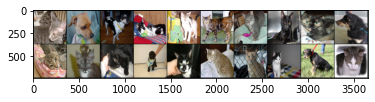

In [20]:
original_image = test_itr.next()

show_image_tensor(original_image)

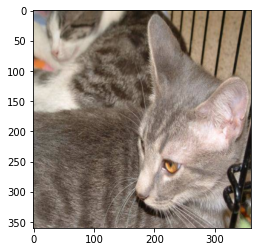

In [21]:
show_image_tensor(original_image[0])

### Resized down

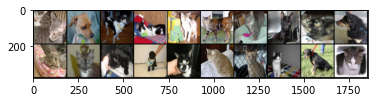

In [22]:
resized_image = transforms.Resize((100, 100))(original_image)
resized_image = transforms.Resize((180, 180))(resized_image)
show_image_tensor(resized_image)

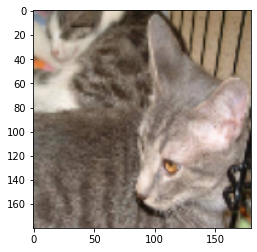

In [23]:
show_image_tensor(resized_image[0])

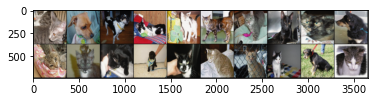

In [24]:
pred = saved_rem(resized_image)
show_image_tensor(pred)

In [25]:
pred_np = pred.detach().numpy()

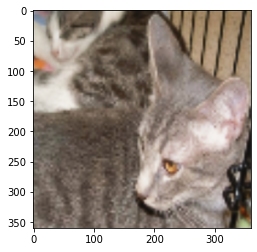

In [26]:

show_image_numpy(pred_np[0])